# Gross-Vitells LEE for a bump hunt

## Preliminaries

Consider the case that we are trying to determine whether a reconstructed mass spectrum has evidence of a new resonant state.  That is, given some signal pdf $s(x;\boldsymbol{\theta})$ and background pdf $b(x;\mathbf{a})$ we would like to determine the amplitude, $A$, of the mixture model,

$$ 
f(x;\mathbf{a}, \mathbf{\theta}) = (1 - A)\,b(x;\mathbf{a}) + A\, s(x;\boldsymbol{\theta})
$$

The preferred figure of merit in such cases is the *profile likelihood ratio*,

$$
q_{0} = \frac{\mathcal{L}(A, \hat{\theta}, \hat{a})}{\mathcal{L}(A=0, \hat{a})}
$$

where the parameters have been optimized for the data.  This quantity has the nice property that is distributed according to a $\chi^{2}_{k}$ distribution where in our case the d.o.f. $k$ corresponds to the number of amplitude terms $A$ and is 1.  This is known as [Wilk's Theorem](https://en.wikipedia.org/wiki/Likelihood-ratio_test#Distribution:_Wilks.E2.80.99_theorem).


Frequently, such searches are undertaken with a specific model in mind that can constrain the search parameters, $\boldsymbol{\theta}$.  In this notebook I will consider the case that the search parameters are not well constrained, and we would like to adjust the probability to observe a resonance-like fluctuation given it could have appeared anywhere in our search space.

Typically, this problem is tackled by carrying out a very large number ($> 10^{6}$) pseudo-experiments which will inevitably be computationally expensive and in some cases infeasible.  The Gross-Vitells approach can be thought of as an extension to Wilk's Therorem where we will factor in the effects of the the unknown search parameters.  This is covered in detail in **citations**.  The important result is that we can represent the excursion probabilities as,

$$
\mathbb{P}[\max_{\theta \in \mathcal{M}} q(\theta) > u] \approx \mathbb{E}[\phi(A_{u})],
$$

where the excursion set of $q$ for some threshold $u$ is,

$$
A_{u} = \{\theta \in \mathcal{M}: q(\theta) > u\},
$$

and $\phi$ is the [Euler Characteristic](https://en.wikipedia.org/wiki/Euler_characteristic) of the excursion set.  To get some intuition about $\phi$, it can be thought of as the number of upcrossings of $q$ for some threshold $u$.

## Higgs to diphoton analysis

In [1]:
# imports and configuration

%cd '/home/naodell/work/nllfit'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2
from tqdm import tqdm_notebook

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft
import nllfit.lookee as lee


/home/naodell/work/nllfit


As an example, we can consider the most famous recent example of a bump hunt: the Higgs boson discovery in the $\gamma\gamma$ channel.  This sample is generated using `MADGRAPH` for calculating the matrix element, `PYTHIA` for hadronization, and finally `DELPHES` for an approximate simulation of the CMS detector response.

(100, 180)

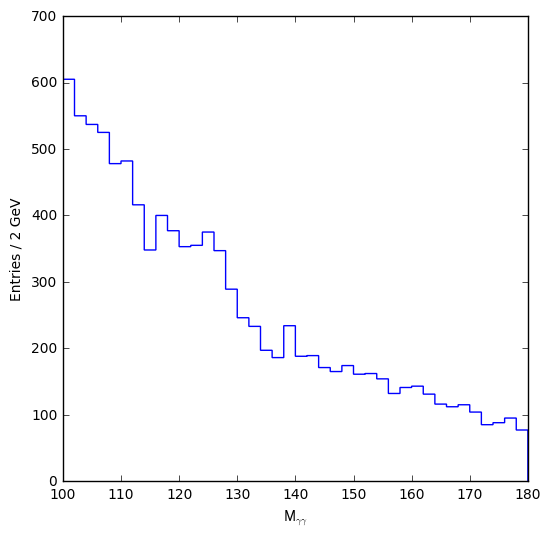

In [2]:
# plot of toy data
df_data  = pd.read_csv('data/toy_hgammagamma.txt')
data_hgg = df_data.diphoton_mass.values
n_total  = data_hgg.size
xlimits  = (100, 180)

plt.figure(figsize=(6,6))
plt.hist(data_hgg, bins=40, range=(100, 180), histtype='step')
plt.xlabel(r'$\sf M_{\gamma\gamma}$')
plt.ylabel('Entries / 2 GeV')
plt.xlim(100, 180)

Next, define the background and signal models. For the background, a third-order Legendre polynomial is used.  For the signal, a Gaussian will be used, though a Voigt profile would be more accurate.  Ultimately, both are characteristically the same in that they are fully specified by the location of the central value and the width of the lineshape.  The bounds on $\mu$ and $\sigma$ should be set to correspond to the scan range.  In this case the bounds for $\mu$ are set to be 5 GeV below/above the maximum/minimum values saved in data.

In [3]:
# pdf definitions
def bg_pdf(x, a, bnds=xlimits):                                                              
    '''                                                                        
    Wrapper for nth order Legendre Polynomial.            
                                                                               
    Parameters:                                                                
    ===========                                                                
    x: data                                                                    
    a: model parameters (a1 and a2)                                            
    '''      
    z   = ft.scale_data(x, xmin=bnds[0], xmax=bnds[1])                                      
    fx  = legval(z, a)*2/(bnds[1] - bnds[0])                             
    return fx                                                                  

def sig_pdf(x, a, normalize=False):                                            
    '''                                                                        
    Second order Legendre Polynomial (normalized to unity) plus a Gaussian.    
                                                                               
    Parameters:                                                                
    ===========                                                                
    x: data                                                                    
    a: model parameters (a1, a2, mu, and sigma)                                
    '''                                                                        
                                                                               
    bg = bg_pdf(x, a[3:])                                                     
    sig = norm.pdf(x, a[1], a[2])                                              
    if normalize:                                                              
        sig_norm = integrate.quad(lambda z: norm.pdf(z, a[1], a[2]), -1, 1)[0] 
    else:                                                                      
        sig_norm = 1.                                                          
                                                                               
    return (1 - a[0])*bg + a[0]*sig/sig_norm                                   


In [31]:
# model initialization
bg_params = Parameters()
bg_params.add_many(
                   ('a0', 0.5, False, None, None, None),
                   ('a1', 0., True, None, None, None),
                   ('a2', 0., True, None, None, None),
                   ('a3', 0., True, None, None, None)
                  )

bg_model  = Model(bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model, verbose=True)
bg_result = bg_fitter.fit(data_hgg, calculate_corr=True)

# print 'bg result'
# bg_params.pretty_print()
# print '\n'

sig_params = Parameters()
sig_params.add_many(
                    ('A'     , 0.01 , True , 0.0  , 1.  , None) ,
                    ('mu'    , 125.  , True , 120. , 130. , None) ,
                    ('sigma' , 1.   , True , 0.45 , 10.  , None)
                   )
sig_params += bg_params.copy()
sig_model  = Model(sig_pdf, sig_params)
sig_fitter = NLLFitter(sig_model, verbose=True)
sig_result = sig_fitter.fit(data_hgg, calculate_corr=True)

# print 'bg+signal result'
# sig_params.pretty_print()

Fit finished with status: 0
[[Variables]]
    a0:   0.5 (fixed)
    a1:  -0.48139443 +/- 0.009167 (1.90%) (init= 0)
    a2:   0.18293974 +/- 0.011612 (6.35%) (init= 0)
    a3:  -0.04536159 +/- 0.012026 (26.51%) (init= 0)

[[Correlation matrix]]
[[ 1.    -0.52   0.156 -0.037]
 [-0.52   1.    -0.472  0.145]
 [ 0.156 -0.472  1.    -0.463]
 [-0.037  0.145 -0.463  1.   ]] 

Fit finished with status: 0
[[Variables]]
    A:       0.02704169 +/- 0.008589 (31.77%) (init= 0.01)
    mu:      125.337921 +/- 0.652649 (0.52%) (init= 125)
    sigma:   2.63579759 +/- 0.751014 (28.49%) (init= 1)
    a0:      0.5 (fixed)
    a1:     -0.47909091 +/- 0.010811 (2.26%) (init= 0)
    a2:      0.20701592 +/- 0.012895 (6.23%) (init= 0)
    a3:     -0.08080959 +/- 0.015917 (19.70%) (init= 0)

[[Correlation matrix]]
[[ 1.    -0.477  0.788 -0.645  0.49   0.384 -0.624]
 [-0.477  1.    -0.574  0.319 -0.292 -0.095  0.268]
 [ 0.788 -0.574  1.    -0.527  0.412  0.284 -0.489]
 [-0.645  0.319 -0.527  1.    -0.663 -0.135

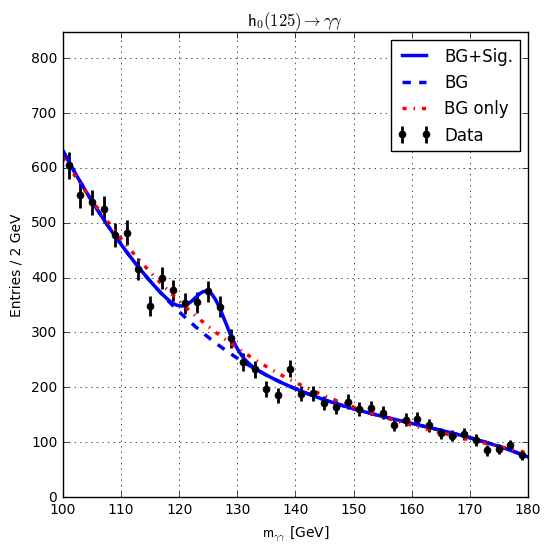

In [5]:
ft.fit_plot_1D(data_hgg, sig_model, bg_model, xlimits, nbins=40, suffix='hgg')

Note that the signal model is the mixture of the background polynomial and the Gaussian.  In both cases, the models are fit to the data so that we can use the parameters for generating MC.  It will be important to know the value of the likelihood ratio so that we can later determine the corresponding global p value.

In [6]:
qmax = 2*(bg_model.calc_nll(data_hgg) - sig_model.calc_nll(data_hgg))
qmax

34.424436893241364

In order to determine the coefficients for the Gross-Vitells treatment, the search parameters will be scanned over a number of pseudo-datasets generated from the background-only model.  This is done by using a [simple acceptance-rejection sampler](https://github.com/naodell/amumu/blob/master/nllfitter/fit_tools.py#L146).  The number of toys necessary to get a good estimate is typically on the order of ten, but I will generate a 1000 for the sake of validation.

In [7]:
# generate simulated data
sims = ft.generator(bg_model.pdf, xlimits, ntoys=20*n_total)
sims = sims.reshape(20, n_total)

Both the mass of the resonance ($\mu$) and its width ($\sigma$) need to be scanned over.  For the mass, we will restrict the range under consideration to masses of 110 GeV to 170 GeV (in practice, the range that is scanned is at the discretion of the analyzer and should be a range of values where you would be willing to accept the presence of an anomaly, i.e., masses that are not a priori excluded).  The range of widths should be treated similarily; a reasonable value for the lower bound should be your experimental resolution and the upper bound should be chosen based on the physics models under consideration.  

The `ScanParameters` class will generate bounded ranges for the parameters under consideration.  The parameters will be allowed to vary within those bounds and take on the values that minimize the NLL.  Choosing the appropriate granularity is up to the discretion of the analyzer.  I would suggest not making the ranges too granular since you will spend a lot more time running the scans with no benefit.  Also, when doing this it makes sense to first consider the effect of one dimensional scans before undertaking higher dimensional scans.

In [8]:
# define scan parameters
sigma_max = sig_params['sigma'].value
nscans = [30, 10]
# bnds   = [(xlimits[0]+10, xlimits[1]-10), (sigma_max, sigma_max)]
bnds   = [(xlimits[0]+10, xlimits[1]-10), (1, 5)]

scan_params = ScanParameters(names  = ['mu', 'sigma'],
                             bounds = bnds,
                             nscans = nscans
                            )

Now we're ready to carry out the scans.  For each toy dataset, we will save the parameters that minimize the nll, the value of the EC for several excursion thresholds `u_0`.  I should mention that I used [Kyle Cranmer's notebook](https://github.com/cranmer/look-elsewhere-2d) on GV as a starting point.  For the most part, my framework is completely independent, but I did take his [code for calculating the EC](https://github.com/cranmer/look-elsewhere-2d).  It makes very nice use of numpy's image convolution modules.

In [9]:
# carry out scans of signal parameters and cacluate EC for varying excursions

bg_fitter.verbose = False # turn off parameter printing
phiscan   = []
qmaxscan  = []
u_0       = np.linspace(0.2, 30., 149)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc='Scanning', 
                            unit_scale=True, 
                            ncols=75, 
                            total=len(sims)):
    # fit background model
    bg_result = bg_fitter.fit(sim, calculate_corr=False)
    if bg_result.status == 0:
        nll_bg = bg_model.calc_nll(sim)
    else:
        continue
        

    # scan over signal parameters
    nllscan, params, dof = sig_fitter.scan(scan_params, sim)
    qscan = -2*(nllscan - nll_bg)
    qmaxscan.append(np.max(qscan))

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans):
        continue
        
    qscan = np.array(qscan).reshape(scan_params.nscans)
    phiscan.append([lee.calculate_euler_characteristic((qscan > u) + 0.) 
                    for u in u_0])

# convert lists to arrays
phiscan     = np.array(phiscan)
qmaxscan    = np.array(qmaxscan)

Having completed the scans and calculated the corresponding EC, the coefficients for the EC densities can be determined.  This is done by carrying out a fit to the scan data.

In [29]:
param_init = [1.,1.]
param_bnds = [(1., np.inf), (1., np.inf)]

kvals      = [1]
scales     = [0.5]
nvals      = lee.get_GV_coefficients(u_0, phiscan, param_init, param_bnds, kvals, scales)
nvals

array([ 24.489,  19.485])

Finally, calculate the relevant statistics and print the results,

In [30]:
### Calculate statistics and print ###
p_local  = 0.5*chi2.sf(qmax, 1)
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, [1], [nvals], [0.5])
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)

N1 = 24.49
N2 = 19.48
local p value       = 2.216e-09
local significance  = 5.87
global p value      = 3.758e-07
global significance = 4.95
trial factor        = 169.60


For the sake of validating this result we can check if our prediction from the Gross-Vitells formalism compares well with the distribution from the toy data.

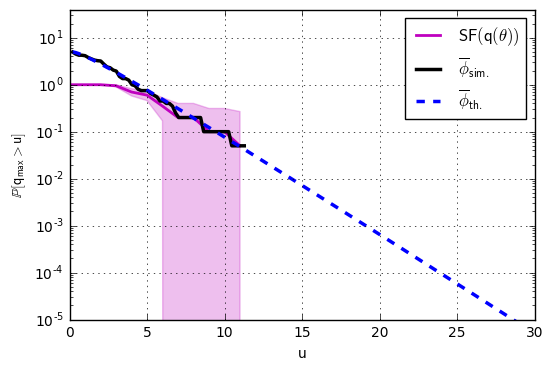

In [13]:
lee.gv_validation_plot(u_0, phiscan, qmaxscan, [nvals], [1], [0.5], None)

## Higgs to ZZ to 4 leptons analysis

Now we will consider the other golden decay channel: $H\rightarrow ZZ \rightarrow 4\ell$.  This channel is distinct from the $H\rightarrow \gamma\gamma$ channel in specifics (background shape, signal shape, and overall event yield), but when it comes to hypothesis testing the two channels should be combined to determine the total significance.

Let's go through the same steps that we went through for the $H\rightarrow \gamma\gamma$ case.

(0, 25)

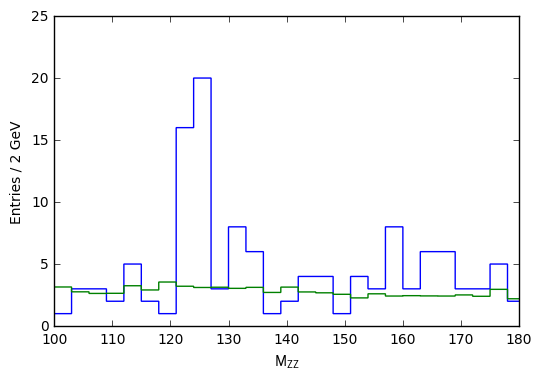

In [14]:
# get the data and plot it
df_data  = pd.read_csv('data/toy_hzz.txt')
data_hzz = df_data.inv_mass.values
n_total  = data_hzz.size

df_bg       = pd.read_csv('data/toy_hzz_bg.txt')
data_hzz_bg = df_bg.inv_mass.values[:7500]

plt.hist(data_hzz, bins=27, range=(100, 181), histtype='step')
plt.hist(data_hzz_bg, bins=27, range=(100, 181), histtype='step', weights=0.01*np.ones(data_hzz_bg.size))
plt.xlabel(r'$\sf M_{ZZ}$')
plt.ylabel('Entries / 2 GeV')
plt.xlim(100, 180)
plt.ylim(0, 25)

In [22]:
bg_fitter.verbose = True
bg_result  = bg_fitter.fit(data_hzz_bg)
bg_params['a1'].vary   = False
bg_params['a2'].vary   = False
bg_params['a3'].vary   = False

# fix bg+signal polynomial parameters to values from bg only simulation
sig_params['a1'].value  = bg_params['a1'].value
sig_params['a2'].value  = bg_params['a2'].value
sig_params['a3'].value  = bg_params['a3'].value
sig_params['a1'].vary   = False
sig_params['a2'].vary   = False
sig_params['a3'].vary   = False

sig_result = sig_fitter.fit(data_hzz)

Fit finished with status: 0
[[Variables]]
    a0:   0.5 (fixed)
    a1:  -0.05247693 (fixed)
    a2:   0.0004593485 (fixed)
    a3:   0.09257043 (fixed)

[[Correlation matrix]]
[[  1.000e+00  -6.078e-02   3.570e-04   7.166e-02]
 [ -6.078e-02   1.000e+00   9.798e-03  -2.920e-02]
 [  3.570e-04   9.798e-03   1.000e+00   9.185e-03]
 [  7.166e-02  -2.920e-02   9.185e-03   1.000e+00]] 

Fit finished with status: 0
[[Variables]]
    A:       0.22416376 +/- 0.051120 (22.81%) (init= 0.01)
    mu:      124.389690 +/- 0.401873 (0.32%) (init= 30)
    sigma:   1.62303570 +/- 0.292435 (18.02%) (init= 1)
    a0:      0.5 (fixed)
    a1:     -0.05247693 (fixed)
    a2:      0.0004593485 (fixed)
    a3:      0.09257043 (fixed)

[[Correlation matrix]]
[[ 1.    -0.02   0.275 -0.296  0.161  0.162 -0.297]
 [-0.02   1.    -0.027  0.02  -0.031  0.028  0.009]
 [ 0.275 -0.027  1.    -0.174  0.096  0.092 -0.171]
 [-0.296  0.02  -0.174  1.    -0.367  0.011  0.208]
 [ 0.161 -0.031  0.096 -0.367  1.    -0.188  0.1

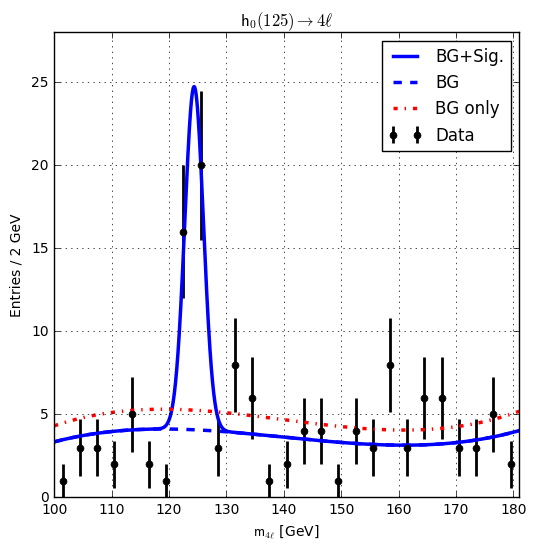

In [23]:
ft.fit_plot_1D(data_hzz, sig_model, bg_model, (100, 181), nbins=27, suffix='hzz')

In [27]:
# generate toys
sims = ft.generator(bg_model.pdf, xlimits, ntoys=500*n_total)
sims = sims.reshape(500, n_total)

# set up scan parameters
sigma_max = sig_params['sigma'].value
nscans = [30, 10]
bnds   = [(xlimits[0]+10, xlimits[1]-10), (1, 5)]
scan_params = ScanParameters(names  = ['mu', 'sigma'],
                             bounds = bnds,
                             nscans = nscans
                            )

# carry out scans over signal parameters
bg_fitter.verbose = False # turn off parameter printing
phiscan   = []
qmaxscan  = []
u_0       = np.linspace(0.01, 30., 300)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc='Scanning', 
                            unit_scale=True, 
                            ncols=75, 
                            total=len(sims)):
    # fit background model
    bg_result = bg_fitter.fit(sim, calculate_corr=False)
    if bg_result.status == 0:
        nll_bg = bg_model.calc_nll(sim)
    else:
        continue
        

    # scan over signal parameters
    nllscan, params, dof = sig_fitter.scan(scan_params, sim)
    qscan = -2*(nllscan - nll_bg)
    qmaxscan.append(np.max(qscan))

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans):
        continue
        
    qscan = np.array(qscan).reshape(scan_params.nscans)
    phiscan.append([lee.calculate_euler_characteristic((qscan > u) + 0.) 
                    for u in u_0])

# convert lists to arrays
phiscan     = np.array(phiscan)
qmaxscan    = np.array(qmaxscan)

N1 = 24.49
N2 = 19.48
local p value       = 2.216e-09
local significance  = 5.87
global p value      = 3.758e-07
global significance = 4.95
trial factor        = 169.60


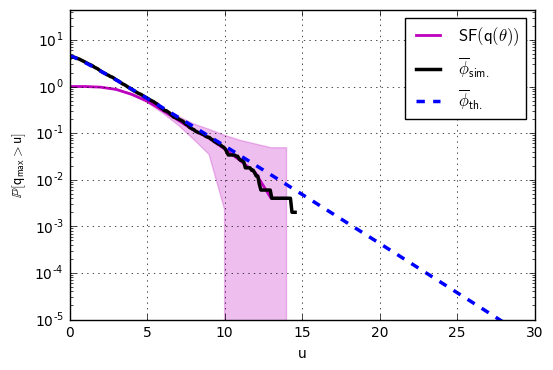

In [28]:
param_init = [1.,1.]
param_bnds = [(0., np.inf), (0., np.inf)]
kvals      = [1]
scales     = [0.5]
nvals      = lee.get_GV_coefficients(u_0, phiscan, param_init, param_bnds, kvals, scales)

### Calculate statistics and print ###
p_local  = 0.5*chi2.sf(qmax, 1)
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, [1], [nvals], [0.5])
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)

lee.gv_validation_plot(u_0, phiscan, qmaxscan, [nvals], [1], [0.5], None)

This looks very good in both cases.  I will consider the case that we carry out the search in both channels simultaneously in a separate notebook.